# Step 3: Normalisation

We have previously discussed the principles behind non-linear registration on this course. As a quick review, the reasons for normalising data to a standard space relate to issues of anatomical variability and the problems this poses for analysing groups of scans. In brief, the statistical analysis of fMRI data is performed in voxel-space. As such, it is necessary for all the images to be the same dimensions *and* for the same voxel coordinates to correspond to the same anatomical locations. Given how substantial anatomical variability can be, this will never be the case for raw fMRI data. As such, normalisation becomes a necessary step in order to bring all the images into the same coordinate space. However, given the complexity of the anatomical differences across subjects, simple affine registration approaches will not be suitable. Instead, we need to use *non-linear* methods to provide the best correspondance between the data and the standard space template.

## Direct Normalisation to a Template

The most basic form of spatial normalisation involves the direct registration of an image to an MNI template. This can be performed as either a *one-step* or *two-step* procedure. 

### One-step Normalisation

In a one-step approach, the image is directly registered with a matching template in MNI space. For instance, a T1 template would be used when normalising an antomical image and an EPI template would be used when normalising a BOLD image. This is shown in {numref}`one-step-norm-fig`. 

```{figure} images/one-step.png
---
width: 800px
name: one-step-norm-fig
---
Illustration of one-step normalisation.
```

Although this approach can work well for anatomical images, the poor resolution of the fMRI data, coupled with the limited contrast of the template, means that there is minimal anatomical information that can be used to improve the alignment. As such, most direct normalisation approaches rely on a *two-step* approach instead. 

### Two-step Normalisation

In a two-step approach, an anatomical image from the same subject is directly registered to a T1 template and then the resultant transformation is applied to the functional data. In theory, this should result in much more accurate normalisation, as the high-resolution anatomical detail from the T1 can be used to derive a much more detailed transformation which can then be applied to the low-resolution functional images. The only proviso is that the functional and anatomical data must be well-aligned before this transformation is estimated, otherwise it will not be accurately applied to the fMRI images. An example of two-step normalisation is shown in {numref}`two-step-norm-fig`.

```{figure} images/two-step-alt.png
---
width: 800px
name: two-step-norm-fig
---
Illustration of two-step normalisation.
```

### Direct Normalisation in SPM

For many years, direct normalisation was the main approach implemented in SPM. This can be seen in the `Old Normalise` tools available under `SPM > Tools > Old Normalise` within the batch system. The MNI templates used for this approach are also still available within the SPM folder under `spm12 > toolbox > OldNorm`, with options for normalising T1, T2, EPI, PET, SPECT and PD (proton density) images. However, in 2005, [Ashburner & Friston](https://pubmed.ncbi.nlm.nih.gov/15955494/) developed a new approach to normalisation known as *unified segmentation*. This is now the default method for normalising fMRI images in SPM, as we will explore below.

## Unified segmentation

In the unified segmentation approach, the generation of normalisation parameters is part of the same algorithm used to segment an anatomical image into the different tissue classes. As such, this is a form of *two-step* normalisation, but one where the generation of the deformation field is part of the segmentation process, rather than through direct registration to an MNI template.

### Gaussian Mixture Models for Segmentation

To understand how this normalisation approach works, we need to first understand how tissue segmentation is performed. Given that different tissue types are fairly easy to discern using a standard T1-weighted structural scan, it stands to reason that the voxel intensities should provide some information about the tissue classes. For instance, white matter is generally brighter than grey matter and CSF tends to be the darkest. We can get a sense of this by plotting the probability distributions for the intensity values of different manually-defined tissue types, as shown in {numref}`seg-tissues-fig`.

```{figure} images/seg-tissues.png
---
width: 500px
name: seg-tissues-fig
---
Example of the different intensity distribution for different tissue classes from a T1-weight anatomical image.
```

Most notable here is both the separation and overlap between the different distributions. If the distributions were entirely separate then we could easily classify the tissues based on intensity alone. Unfortunately, the degree of overlap between these distribution causes problems in terms of deciding whether a voxel is one tissue type or another. Putting this issue to one side for now, we can model the probability distributions for different tissues in an image by using a *Gaussian Mixture Model*. This is illustrated in {numref}`gauss-mix-fig`, where the yellow bars represent the histogram of image intensities and the black line represents the overall shape of the distribution. The blue lines demonstrate how this overall shape can be approximated by mixing together Gaussian distributions with different means and variances. This is very similar to the idea of recreating a signal using a linear combination of sines and cosines. As such, this approach can be thought of as defining a Gaussian *basis set* for the image intensities.

```{figure} images/gauss-mix.png
---
width: 600px
name: gauss-mix-fig
---
Illustration of a Gaussian mixture model.
```

After estimating the shapes of all the Gaussian distributions, we could then assess the probability that a voxel belongs to a tissue class by calculating the probability of its intensity value across all the distributions. Whichever distribution gives the highest probability represents the most likely tissue class. However, as indicated earlier, one of the issues is that there is a degree of overlap between these distributions. This means that certain intensity values will have similar probabilities for multiple tissue types. This speaks to a more general issue known as the *partial volume effect*, where a voxel can contain multiple tissue types. As such, additional information is needed in order to make a decision about the tissues classification. This additional information comes in the form of *tissue probability maps* (TPMs). These are images that contain probabilities indicating how likely each voxel in the brain is to be a particular tissue type. These probabilities can be used to compliment the intensity information from the mixture model.

### Tissue Probability Maps (TPMs)

In terms of normalisation, the most important element of the unified segmentation algorithm is the TPMs. Examples of the TPMs included with SPM are given in {numref}`tpm-fig` for grey matter, white matter, CSF and air/background. These images are derived from the [ICBM Probabilistic Atlases](http://www.bmap.ucla.edu/portfolio/atlases/ICBM_Probabilistic_Atlases/), which are built from hundreds of scans of young healthy adults. As these scans combine information from across multiple individuals, they are defined in MNI space. As such, in order to use the TPMs to make decisions about an individual subject's anatomy, the TPMs must be warped from MNI space into subject-space. As such, a deformation field that warps the TPMs from MNI-space to subject-space is created during the process of segmentation. Inverting this field provides the transformation from subject-space to MNI space that can be applied to normalise the functional data.

```{figure} images/tpm.png
---
width: 400px
name: tpm-fig
---
Example of the tissue probability maps (TPMs) for grey matter, white matter, CSF and air.
```

## Anatomical and Functional Registration

Irrespective of whether we are using a direct normalisation approach or the unified segmentation approach, two-step normalisation depends upon accurate registration between the functional and anatomical data. If this is not the case, then the deformation field will warp the wrong parts of the functional image and the transformation will not work. This is demonstrated in {numref}`anat-func-reg-fig`. As such, the first step in normalisation is to register the structural and functional images together in world-space. Although this could be achieved in a variety of ways, the most efficient is to move the anatomical data so that it is aligned with the functional data. In terms of a reference, a single volume of the functional series could be selected, or an *average* volume after motion correction. In theory, the latter should be the most accurate representation of the entire fMRI series. As such, in SPM, it is usual to save the mean functional volume after realignment to use as the reference image for registration of the anatomical scan prior to normalisation.

```{figure} images/anat-func-reg.png
---
width: 600px
name: anat-func-reg-fig
---
Example of how misregistration between an anatomical and functional scan prior to two-step normalisation (*top*) will cause the warping parameters to be applied incorrectly to the functional data (*bottom*).
```

## Normalising functional data in SPM

Now that we have discussed the theory of spatial normalisation, we can examine how to perform this step using SPM.

### Using the Graphical Batch System

The video below will demonstrate how to normalise the realigned and slice timing corrected functional data, using the SPM graphical interface.

<div style="max-width: 1280px"><div style="position: relative; padding-bottom: 56.25%; height: 0; overflow: hidden;"><iframe src="https://livemanchesterac.sharepoint.com/sites/UOM-FBMH-MSc-NCCN/_layouts/15/embed.aspx?UniqueId=a33e96b4-97a3-48af-9a47-ef9c17b11c2c&embed=%7B%22hvm%22%3Atrue%2C%22ust%22%3Atrue%7D&referrer=StreamWebApp&referrerScenario=EmbedDialog.Create" width="1280" height="720" frameborder="0" scrolling="no" allowfullscreen title="5.Normalisation.mov" style="border:none; position: absolute; top: 0; left: 0; right: 0; bottom: 0; height: 100%; max-width: 100%;"></iframe></div></div>

### Using MATLAB Code

Unlike the previous preprocessing steps, there are no low-level functions in SPM for performing unified segmentationn. As such, if we want to script this step, we have to use the code generated by the batch system. This will be discussed as part of *Advanced Image Analysis*, later in the course. For the time being, the older direct approach to normalisation is still available in the form of the `spm_normalise` and `spm_write_sn` functions. To begin with, we use the `spm_coreg` function to register the anatomical and mean functional images.


SPM12: spm_coreg (v7320)                           15:22:29 - 06/11/2023


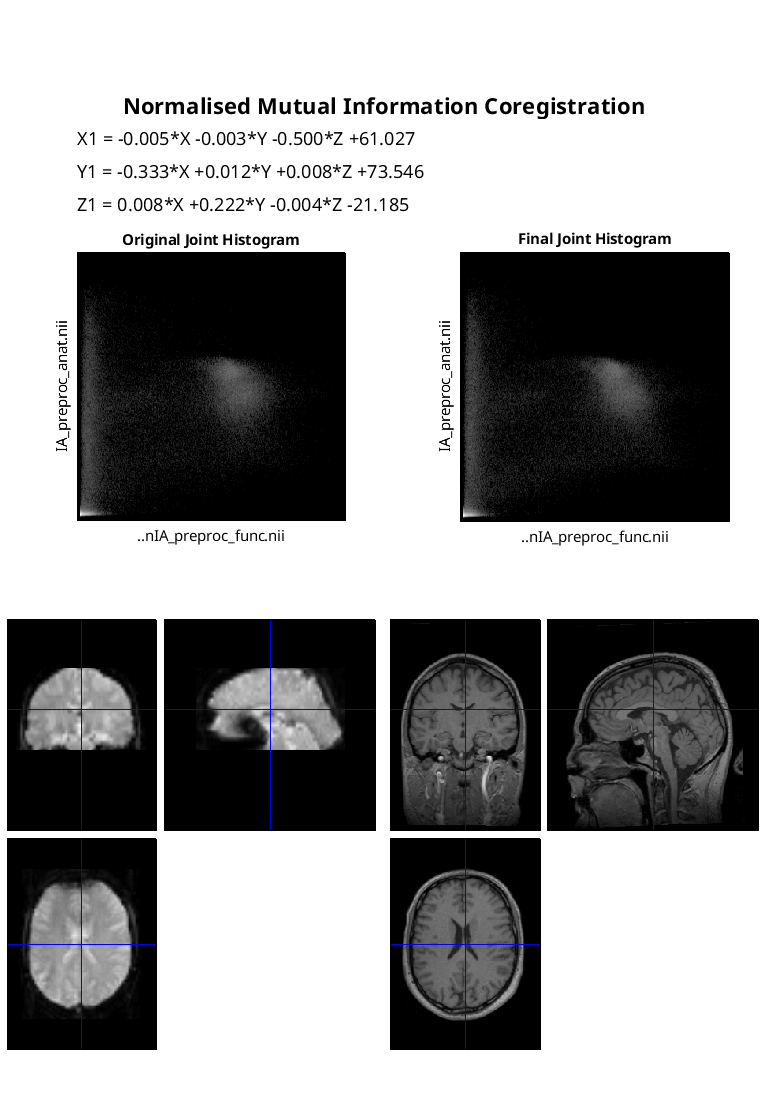

Printing 'Graphics' figure to:
  /home/martyn/Downloads/spm_2023Nov06.ps
Completed                               :          15:22:34 - 06/11/2023


In [5]:
% Launch SPM
spm('defaults','FMRI');
spm_figure('GetWin','Graphics');                    % Open graphics window for plots
oldnorm = fullfile(spm('dir'),'toolbox','OldNorm'); % Path to OldNorm toolbox
addpath(oldnorm);                                   % Add the Old Normalise functions

% Load data
func  = spm_vol('arIA_preproc_func.nii');          % Motion and slice timing corrected data 
mfunc = spm_vol('meanIA_preproc_func.nii');        % Mean functional (from realignment)
anat  = spm_vol('IA_preproc_anat.nii');            % Anatomical scan

% Coregister anat -> mean
copts = spm_get_defaults('coreg.estimate');
spm_coreg(mfunc,anat,copts);

Then we use the `spm_normalise` and `spm_write_sn` functions to estimate and apply the warpings to the functional data.

Smoothing by 0 & 8mm..
Coarse Affine Registration..
Fine Affine Registration..
3D CT Norm...
 iteration  1:  FWHM =  17.38 Var = 10.6076
 iteration  2:  FWHM =  13.49 Var = 2.08803
 iteration  3:  FWHM =  12.86 Var = 1.41758
 iteration  4:  FWHM =  12.69 Var = 1.25582
 iteration  5:  FWHM =  12.65 Var = 1.2107
 iteration  6:  FWHM =  12.64 Var = 1.19879
 iteration  7:  FWHM =  12.65 Var = 1.19538
 iteration  8:  FWHM =  12.65 Var = 1.19327
 iteration  9:  FWHM =  12.65 Var = 1.19175
 iteration 10:  FWHM =  12.64 Var = 1.19175
 iteration 11:  FWHM =  12.65 Var = 1.19068
 iteration 12:  FWHM =  12.64 Var = 1.19021
 iteration 13:  FWHM =  12.64 Var = 1.1893
 iteration 14:  FWHM =  12.63 Var = 1.18903
 iteration 15:  FWHM =  12.64 Var = 1.18759
 iteration 16:  FWHM =  12.63 Var = 1.18759


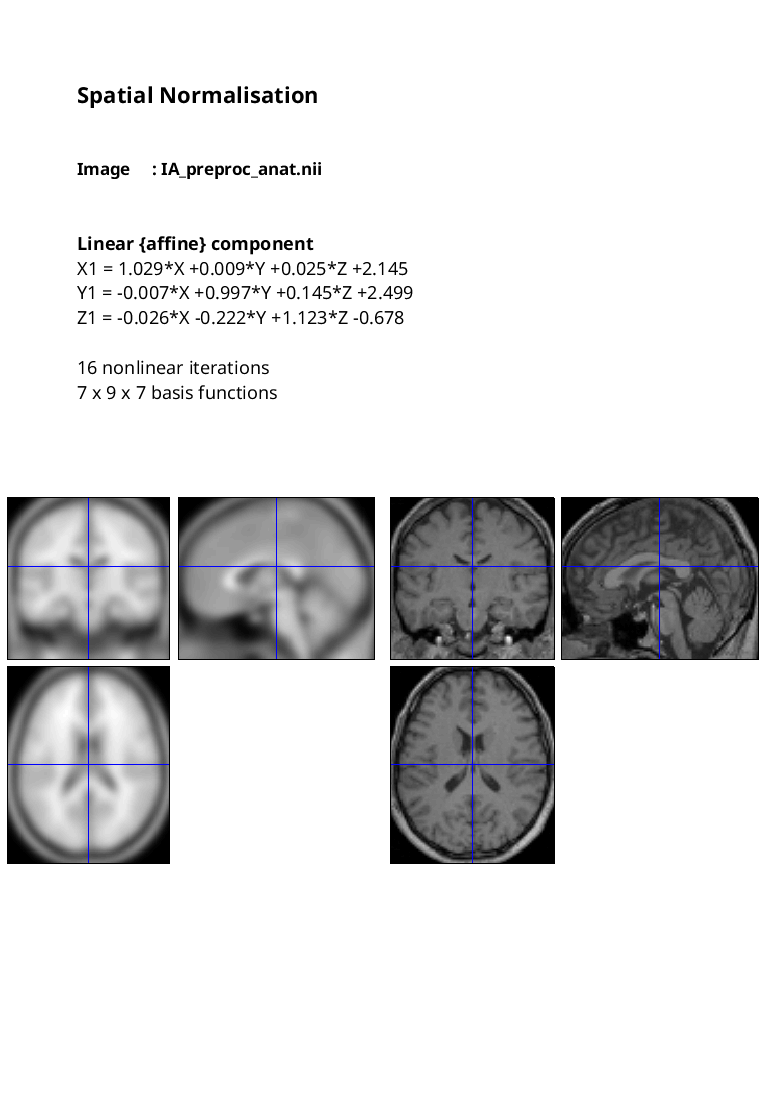


SPM12: spm_write_sn (v4878)                        15:22:56 - 06/11/2023
Completed                               :          15:22:56 - 06/11/2023
Printing 'Graphics' figure to:
  /home/martyn/Downloads/spm_2023Nov06.ps
Saving Parameters..

SPM12: spm_write_sn (v4878)                        15:22:56 - 06/11/2023
Completed                               :          15:23:20 - 06/11/2023

SPM12: spm_write_sn (v4878)                        15:23:20 - 06/11/2023
Completed                               :          15:23:20 - 06/11/2023


In [6]:
% Normalise (estimate)
template = spm_vol(fullfile(oldnorm,'T1.nii'));                  % T1 MNI template
eopts    = spm_get_defaults('old.normalise.estimate');
warps    = spm_normalise(template,anat,'warps.mat',[],[],eopts);

% Normalise (resample)
ropts = spm_get_defaults('old.normalise.write');
spm_write_sn(func,warps,ropts);
spm_write_sn(anat,warps,ropts);

Finally, the results of the normalisation can be checked using `spm_check_registration`


SPM12: spm_check_registration (v7759)              15:23:31 - 06/11/2023
Display /home/martyn/Documents/MATLAB/spm12/toolbox/OldNorm/T1.nii,1
        warIA_preproc_func.nii,1
        wIA_preproc_anat.nii,1


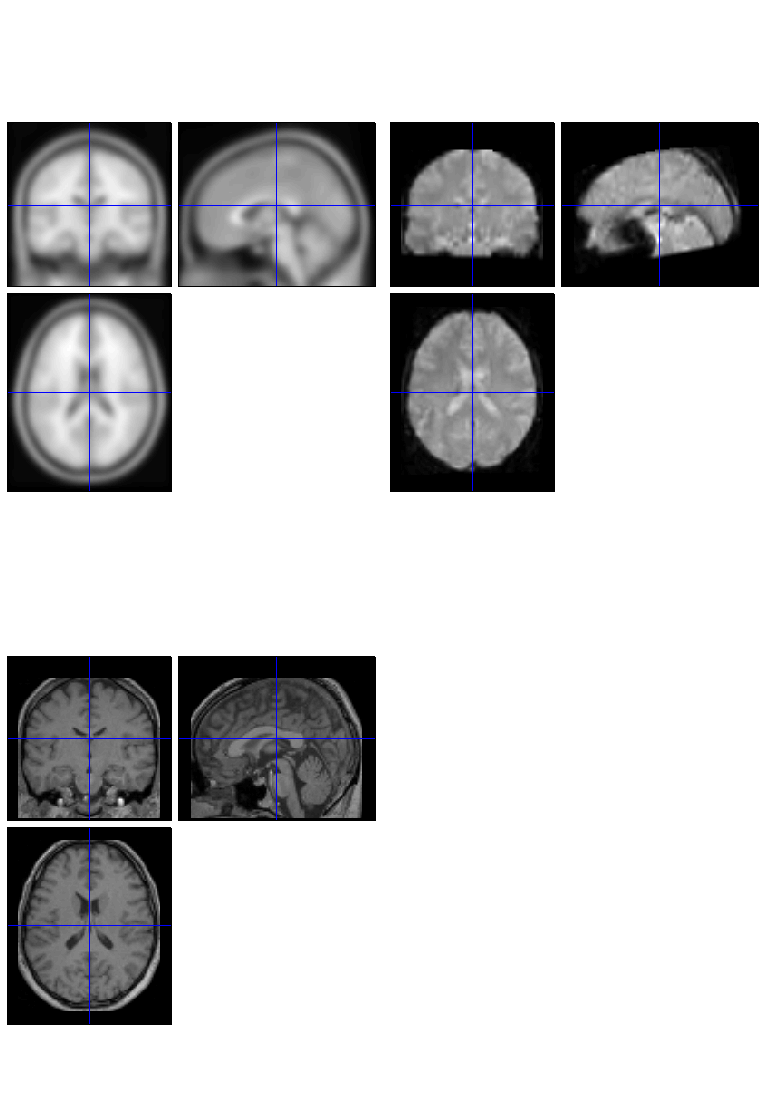

In [7]:
% Check results
spm_check_registration(fullfile(oldnorm,'T1.nii'), ... % Template 
                       'warIA_preproc_func.nii,1', ... % Normalised functional (volume 1)
                       'wIA_preproc_anat.nii');        % Normalised anatomical